#Анощенкова Анна Дмитриевна 3824М1ПМкн


#Лабораторная работа №1 «Метод обратного распространения ошибки»

##Конфигурация нейронной сети

1. Входной слой содержит w x h нейронов, что соответствует разрешению одноканального изображения. Для набора MNIST это составляет 28 x 28.
2. Выходной слой содержит k нейронов, что соответствует количеству классов изображений. Для задачи классификации рукописных цифр MNIST — 10 классов.
3. Скрытый слой содержит s нейронов (параметр).
4. Параметры метода обучения:
   * Скорость обучения (learning rate)
   * Размер пачки данных (batch size)
   * Количество эпох
5. Функции активации:
   * На скрытом слое — функция ReLU.
   * На выходном слое — функция softmax.
   * Входной слой не содержит функции активации
6. Функция ошибки — кросс-энтропия.
7. Контрольные параметры для демонстрации работы нейронной сети:
   * Размер пачки данных: от 8 до 64 изображений
   * Скорость обучения: 0.1.
   * Количество скрытых нейронов s: 300.
   * Количество эпох: 20.

In [1]:
import numpy as np
import time

# Загружаем данные

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(-1, 28,28).astype(np.float32) / 255.0
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [3]:
X_train = load_mnist_images('/content/train-images.idx3-ubyte')
y_train = load_mnist_labels('/content/train-labels.idx1-ubyte')
X_test  = load_mnist_images('/content/t10k-images.idx3-ubyte')
y_test  = load_mnist_labels('/content/t10k-labels.idx1-ubyte')

# Проверим размерности
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


Тренировочные данные

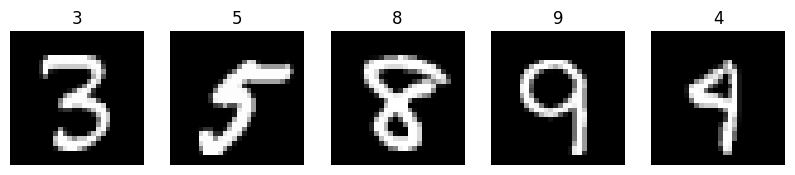

In [4]:
import matplotlib.pyplot as plt

random_indices = np.random.choice(X_train.shape[0], size=5, replace=False)

plt.figure(figsize=(10,2))
for i, idx in enumerate(random_indices):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(y_train[idx])
    plt.axis('off')
plt.show()

Тестовые данные

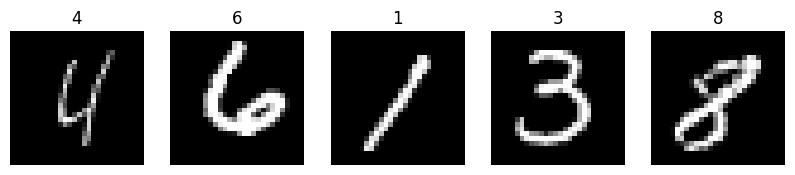

In [5]:
random_indices_test = np.random.choice(X_test.shape[0], size=5, replace=False)

plt.figure(figsize=(10,2))
for i, idx in enumerate(random_indices_test):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(y_test[idx])
    plt.axis('off')
plt.show()

Функция активации скрытого слоя: ReLU

In [6]:
def relu(x):
    return np.maximum(0, x)

Производная ReLU

In [7]:
def relu_grad(x):
    return (x > 0).astype(np.float32)

Функция активации выходного слоя: Softmax

In [8]:
def softmax(x):
    ex = np.exp(x)
    return ex / np.sum(ex, axis=1, keepdims=True)

Функция потерь: Кросс-энтропия

In [9]:
def cross_entropy_loss(probs, labels):
    return -np.mean(np.log(probs[np.arange(labels.shape[0]), labels]))

Функция accuracy

In [10]:
def accuracy(probs, labels):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == labels)

dataloader

In [11]:
def dataloader(X, y, batch_size=64):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

Гиперпараметры

In [12]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
lr = 0.1
epochs = 20
batch_size = 64

Используется инициализация He Initialization, оптимальная для ReLU

In [13]:
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
b2 = np.zeros((1, output_size))

Обучение

In [14]:
for epoch in range(epochs):
    start = time.time()
    total_loss = 0
    num_batches = 0

    for X_batch, y_batch in dataloader(X_train, y_train, batch_size=batch_size):
        X_batch = X_batch.reshape(X_batch.shape[0], -1)
        num_batches += 1

        # Прямой проход
        z1 = X_batch @ W1 + b1
        a1 = relu(z1)
        z2 = a1 @ W2 + b2
        a2 = softmax(z2)

        loss = cross_entropy_loss(a2, y_batch)
        total_loss += loss

        # Обратный проход
        dZ2 = a2
        dZ2[np.arange(y_batch.shape[0]), y_batch] -= 1
        dZ2 /= y_batch.shape[0]

        dW2 = a1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * relu_grad(z1)

        dW1 = X_batch.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Обновление весов
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2


    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    train_probs = softmax(relu(X_train_flat @ W1 + b1) @ W2 + b2)
    train_acc = accuracy(train_probs, y_train)
    print(f"Эпоха {epoch+1}/{epochs} | Loss: {total_loss/num_batches:.4f} | Accuracy на train: {train_acc*100:.2f}% | Время: {time.time()-start:.2f}с")

X_test_flat = X_test.reshape(X_test.shape[0], -1)
test_probs = softmax(relu(X_test_flat @ W1 + b1) @ W2 + b2)
test_acc = accuracy(test_probs, y_test)
print(f"\nAccuracy на test: {test_acc*100:.2f}%")

Эпоха 1/20 | Loss: 0.3599 | Accuracy на train: 93.59% | Время: 4.37с
Эпоха 2/20 | Loss: 0.1887 | Accuracy на train: 95.72% | Время: 3.17с
Эпоха 3/20 | Loss: 0.1393 | Accuracy на train: 96.79% | Время: 2.97с
Эпоха 4/20 | Loss: 0.1112 | Accuracy на train: 97.43% | Время: 4.10с
Эпоха 5/20 | Loss: 0.0925 | Accuracy на train: 97.58% | Время: 3.20с
Эпоха 6/20 | Loss: 0.0793 | Accuracy на train: 98.17% | Время: 3.17с
Эпоха 7/20 | Loss: 0.0689 | Accuracy на train: 98.40% | Время: 3.05с
Эпоха 8/20 | Loss: 0.0604 | Accuracy на train: 98.62% | Время: 4.41с
Эпоха 9/20 | Loss: 0.0537 | Accuracy на train: 98.85% | Время: 3.11с
Эпоха 10/20 | Loss: 0.0481 | Accuracy на train: 98.92% | Время: 3.07с
Эпоха 11/20 | Loss: 0.0428 | Accuracy на train: 99.14% | Время: 4.21с
Эпоха 12/20 | Loss: 0.0390 | Accuracy на train: 99.16% | Время: 3.23с
Эпоха 13/20 | Loss: 0.0350 | Accuracy на train: 99.37% | Время: 3.26с
Эпоха 14/20 | Loss: 0.0318 | Accuracy на train: 99.46% | Время: 3.09с
Эпоха 15/20 | Loss: 0.0288 | 

Точность на тестовой выборке примерно 98%

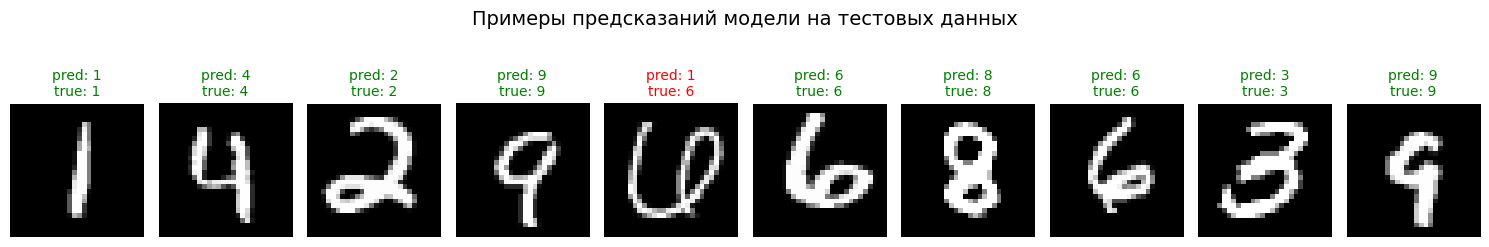

In [21]:
# Визуализация предсказаний на тестовых данных
preds_test = np.argmax(test_probs, axis=1)
n = 10
indices = np.random.choice(X_test.shape[0], size=n, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, n, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    true_label = y_test[idx]
    pred_label = preds_test[idx]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'pred: {pred_label}\ntrue: {true_label}', color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Примеры предсказаний модели на тестовых данных', fontsize=14)
plt.tight_layout()
plt.show()
